In [69]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [70]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/16h5_s_z_2-4-6-8-10_720_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8,10]

In [71]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [72]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,8.782432
1,0.521732,2.607496
2,2.643071,12.019321
3,2.998963,4.597394
4,8.204559,2.089604
...,...,...
1030,113.340234,12.615003
1031,115.551266,8.821924
1032,116.892225,5.399960
1033,118.157073,2.410818


<AxesSubplot:xlabel='relative_time'>

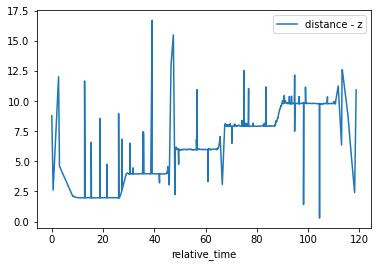

In [73]:
# initial graph
df.plot(x='relative_time', y=target)

In [74]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .01)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [75]:
# the amount of data points we are left with
len(x[peaks])

126

In [76]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

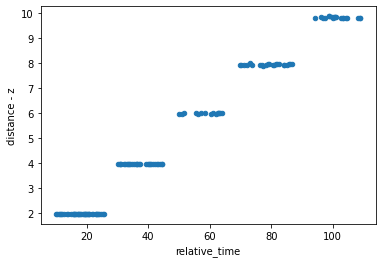

In [77]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [78]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
25,10.095030,1.988969,2
29,10.445126,1.981787,2
36,11.077830,1.983022,2
40,11.441707,1.979422,2
43,11.714670,1.974954,2
...,...,...,...
957,104.233259,9.794761,10
965,104.786744,9.790002,10
1002,108.121137,9.795913,10
1008,108.705643,9.798352,10


In [79]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [80]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [81]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(3)

,relative_time,distance - z,true_distance,error
183,24.752275,1.975847,2,0.024153
188,25.199072,1.976624,2,0.023376
194,25.806198,1.973280,2,0.026720
379,43.954669,3.965543,4,0.034457
384,44.402091,3.969175,4,0.030825
386,44.584923,3.969006,4,0.030994
559,63.143780,6.009527,6,-0.009527
561,63.331070,6.012574,6,-0.012574
567,63.897462,6.009624,6,-0.009624
770,85.908602,7.936924,8,0.063076


In [82]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,39.0,0.021291,0.004381,0.011031,0.017671,0.021213,0.024907,0.029044
4,29.0,0.034259,0.007442,0.020051,0.029031,0.034047,0.041196,0.045940
6,15.0,0.007378,0.013531,-0.012574,-0.004202,0.006456,0.020478,0.027191
8,23.0,0.072056,0.019338,0.013080,0.062094,0.070143,0.084080,0.106280
10,20.0,0.190948,0.017860,0.142863,0.185516,0.192848,0.203893,0.212590


In [83]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

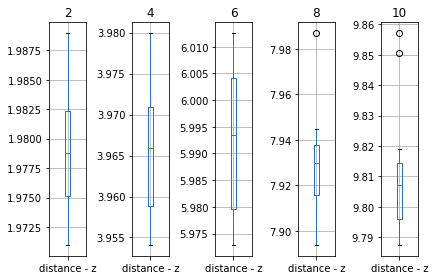

In [84]:
box_plotter(target)

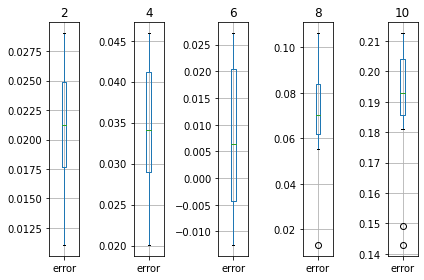

In [85]:
box_plotter('error')